In [1]:
print("hello world")

hello world


In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from langchain_groq import ChatGroq


c:\Users\hp\anaconda3\envs\pizzaapi\lib\site-packages\torch\cuda\__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [4]:
llm = ChatGroq(model="openai/gpt-oss-20b", api_key=os.getenv("GROQ_API_KEY"))

In [5]:
from langchain_tavily import TavilySearch
tool = TavilySearch(max_results=2, api_key=os.getenv("TAVILY_API_KEY"))

In [6]:
tool

TavilySearch(max_results=2, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********'), api_base_url=None))

In [7]:
def multiply(a:int, b:int) -> int:
    """Multiply two integers. Use only if asked to calculate a product.

    Args:
        a (int): first int.
        b (int): second int.

    Returns:
        int: output int

    """
    return a * b

In [8]:
tools = [tool, multiply]

In [9]:
llm_with_tools = llm.bind_tools(tools)

In [10]:
from typing_extensions import Annotated
from typing import TypedDict
from langgraph.graph.message import add_messages

In [11]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [12]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", tool_calling_llm)
graph_builder.add_node("tool_node", ToolNode(tools))

graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    {
        "tools": "tool_node",
        "end": END,
    }
)
graph_builder.add_edge("tool_node", END)

graph = graph_builder.compile() 

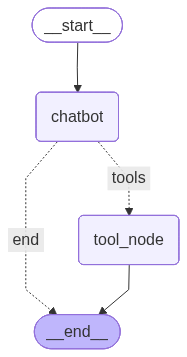

In [13]:
graph

In [14]:
response = graph.invoke({'messages': 'give me recent ai news made yesterday'})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

give me recent ai news made yesterday
================================== Ai Message ==================================
Tool Calls:
  tavily_search (fc_3c29b283-21f0-453d-b34e-a1ede0c5bb3a)
 Call ID: fc_3c29b283-21f0-453d-b34e-a1ede0c5bb3a
  Args:
    end_date: 2025-12-09
    query: AI news December 9 2025
    search_depth: advanced
    start_date: 2025-12-09
    topic: news
================================= Tool Message =================================
Name: tavily_search

{'error': ValueError('Error 400: start_date and end_date cannot be the same')}


In [15]:
response = graph.invoke({'messages': 'what is 12 multiplied by 13'})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what is 12 multiplied by 13
================================== Ai Message ==================================
Tool Calls:
  multiply (fc_67499145-bbff-41e8-98f2-6465420452b4)
 Call ID: fc_67499145-bbff-41e8-98f2-6465420452b4
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: multiply

156


In [16]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", tool_calling_llm)
graph_builder.add_node("tool_node", ToolNode(tools))

graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    {
        "tools": "tool_node",
        "__end__": END,
    }
)
graph_builder.add_edge("tool_node", "chatbot")

graph = graph_builder.compile() 

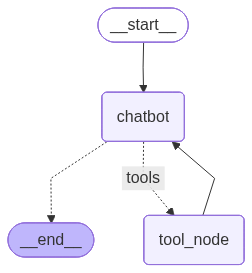

In [17]:
graph

In [18]:
response = graph.invoke({'messages': 'give me recent ai news made yesterday and what is 12 multiplied by 13'})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

give me recent ai news made yesterday and what is 12 multiplied by 13
================================== Ai Message ==================================
Tool Calls:
  tavily_search (fc_a122ac4c-1f8e-423d-a021-d1869c04b838)
 Call ID: fc_a122ac4c-1f8e-423d-a021-d1869c04b838
  Args:
    query: AI news yesterday
    search_depth: basic
================================= Tool Message =================================
Name: tavily_search

{"query": "AI news yesterday", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.wsj.com/tech/ai?gaa_at=eafs&gaa_n=AWEtsqdsTxjN3u4Wp3dcoERHwF9wjTjd_YrWuyAaDdhQxcb4fLSD3Orpaexz&gaa_ts=693a0415&gaa_sig=thEkcBw23AR7vqcQAS8uK4OpRpaJHrl-tzj6NHtF0nYQg3XthBodvik02hmmaY7R-9XT1pXOzmpaBf8p3yenfg%3D%3D", "title": "Artificial Intelligence - Latest AI News and Analysis - WSJ.com", "content": "Artificial Intelligence · Bezos and Musk Race to Bring Data

In [19]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver


memory = MemorySaver()

def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", tool_calling_llm)
graph_builder.add_node("tool_node", ToolNode(tools))

graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    {
        "tools": "tool_node",
        "__end__": END,
    }
)
graph_builder.add_edge("tool_node", "chatbot")


graph = graph_builder.compile(checkpointer=memory) 

In [26]:
config = {"configurable" : {"thread_id":"1"}}

In [24]:
response = graph.invoke({'messages': 'What is my name?'}, config=config)

In [25]:
response['messages'][-1].content

'Your name is Kyeremeh.'

In [27]:
config = {"configurable" : {"thread_id":"2"}}

In [28]:
response = graph.invoke({'messages': 'What is my name?'}, config=config)
response['messages'][-1].content

'I don’t have that information. Could you let me know what you’d like me to call you?'